# Inspecting INDRA Statements and assembled models
In this example we look at how intermediate results of the assembly process from word models to executable models can be inspected. We first import the necessary modules of INDRA.

In [1]:
%pylab inline
import json
from indra.processors import trips
from indra.statements import draw_stmt_graph, stmts_to_json

Populating the interactive namespace from numpy and matplotlib


## Collecting Statements from reading
First, we use the TRIPS system via INDRA's `trips` module to read two sentences which describe distinct mechanistic hypotheses about ATM phosphorylation.

In [2]:
text = 'Active ATM phosphorylates itself. Active ATM phosphorylates another ATM molecule.'
tp = trips.process_text(text)

Here `tp` is a `TripsProcessor` object whose extracted Statements can be accessed in a list. 

## Printing Statements as objects
It is possible to look at the string representation of the extracted INDRA Statements as below. 

In [3]:
tp.statements

[Autophosphorylation(ATM(activity: True)),
 Phosphorylation(ATM(activity: True), ATM())]

The first Statement, obtained by reading "Active ATM phosphorylates itself", represents the Autophosphorylation of ATM with ATM being in an active state. Here `activity` stands for generic molecular activity and `True` indicates an active as opposed to an inactive state.

The second Statement, obtained from "Active ATM phosphorylates another ATM molecule" is a Phosphorylation with the enzyme ATM being in an active state phosphorylating another ATM as a substrate.


## Drawing Statements as graphs
Next, we can use the `draw_stmt_graph` function to display the Statements produced by reading and INDRA input processing as a graph. The root of each tree is the type of the Statement, in this case Autophosphorylation. The arguments of the Statement branch off from the root. In this case the enzyme argument of Autophosphorylation is an Agent with name ATM. Its database references can be inspected under the `db_refs` property. 

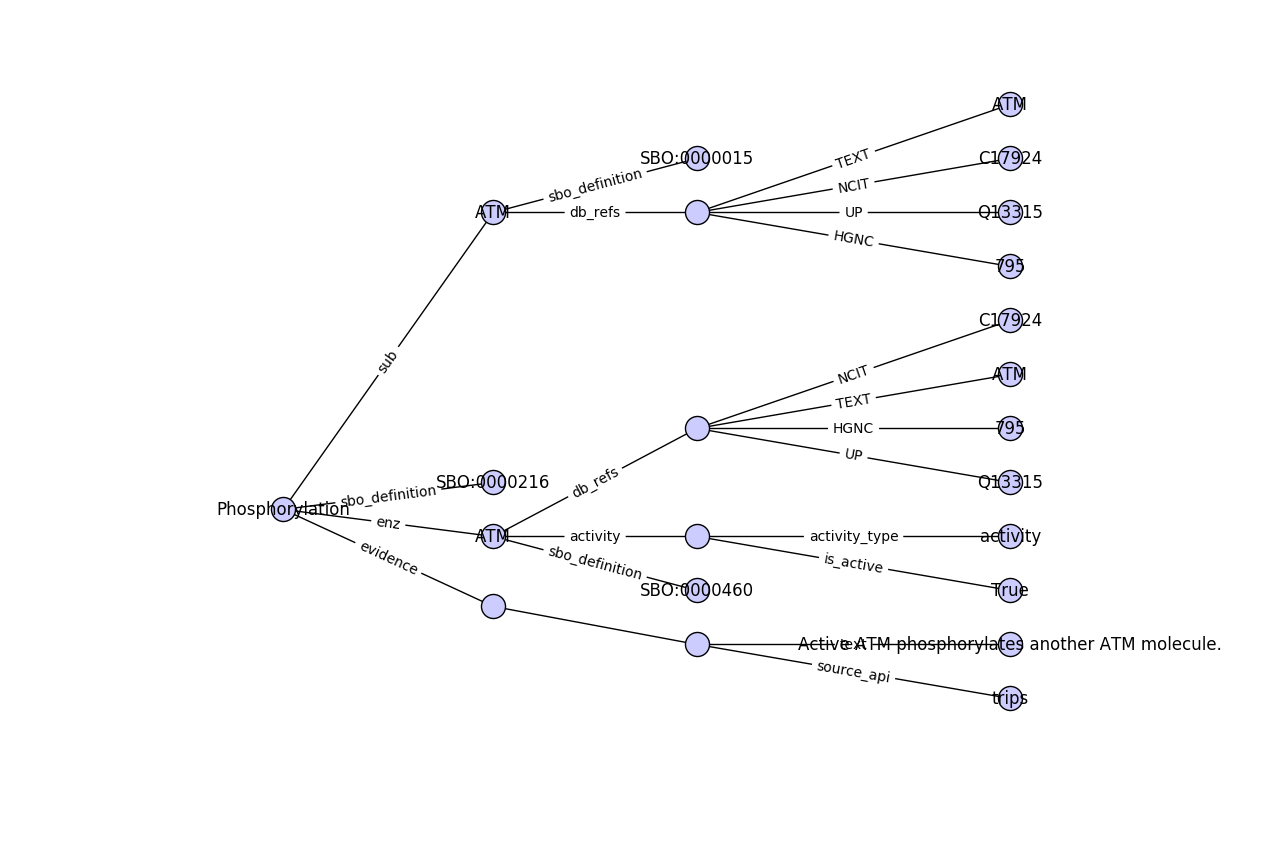

In [21]:
pylab.rcParams['figure.figsize'] = (12, 8)
draw_stmt_graph(tp.statements[1:])

## Printing / exchanging Statements as JSON

INDRA Statements can be serialized into JSON format. This is a human-readable and editable form of INDRA Statements which is independent of Python and can therefore be used as a platform-independent data exchange format for Statements. The function `stmts_to_json` in the `indra.statements` module takes a list of Statements and returns a JSON as a dictionary. Below we pretty-print this JSON as a string with indentations. 

In [5]:
statements_json = stmts_to_json(tp.statements)
print(json.dumps(statements_json, indent=1))

[
 {
  "type": "Autophosphorylation",
  "enz": {
   "name": "ATM",
   "activity": {
    "is_active": true,
    "activity_type": "activity"
   },
   "db_refs": {
    "HGNC": "795",
    "UP": "Q13315",
    "NCIT": "C17924",
    "TEXT": "ATM"
   },
   "sbo_definition": "http://identifiers.org/sbo/SBO:0000460"
  },
  "evidence": [
   {
    "source_api": "trips",
    "text": "Active ATM phosphorylates itself."
   }
  ],
  "id": "effa36d4-5ef2-4ad5-b7ee-8d9c9d58163a",
  "sbo_definition": "http://identifiers.org/sbo/SBO:0000216"
 },
 {
  "type": "Phosphorylation",
  "enz": {
   "name": "ATM",
   "activity": {
    "is_active": true,
    "activity_type": "activity"
   },
   "db_refs": {
    "HGNC": "795",
    "UP": "Q13315",
    "NCIT": "C17924",
    "TEXT": "ATM"
   },
   "sbo_definition": "http://identifiers.org/sbo/SBO:0000460"
  },
  "sub": {
   "name": "ATM",
   "db_refs": {
    "HGNC": "795",
    "UP": "Q13315",
    "NCIT": "C17924",
    "TEXT": "ATM"
   },
   "sbo_definition": "http://id

## Inspecting assembled rule-based models
We now assemble two PySB models, one for each Statement.

In [6]:
from indra.assemblers import pysb_assembler
pa = pysb_assembler.PysbAssembler()
pa.add_statements([tp.statements[0]])
model1 = pa.make_model()

We can examine the properties of the PySB model object before exporting it. As seen below, the model has a single Monomer and Rule, and two Parameters.

In [7]:
model1

<Model 'None' (monomers: 1, rules: 1, parameters: 2, expressions: 0, compartments: 0) at 0x10b358668>

We can look at the ATM Monomer and its sites. ATM has an `activity` site which can be either `active` of `inactive`. It also has a `phospho` site with `u` and `p` states.

In [8]:
model1.monomers['ATM']

Monomer('ATM', ['activity', 'phospho'], {'activity': ['inactive', 'active'], 'phospho': ['u', 'p']})

The rule representing ATM autophosphorylation can be inspected below. The rule is parameterized by the forward rate `kf_a_autophos_1`.

In [9]:
model1.rules[0]

Rule('ATM_autophospho_ATM_phospho', ATM(activity='active', phospho='u') >> ATM(activity='active', phospho='p'), kf_a_autophos_1)

We now assemble a model for the second Statement.

In [10]:
pa = pysb_assembler.PysbAssembler()
pa.add_statements([tp.statements[1]])
model2 = pa.make_model()

In [11]:
model2

<Model 'None' (monomers: 1, rules: 1, parameters: 2, expressions: 0, compartments: 0) at 0x123610e48>

In [12]:
model2.monomers['ATM']

Monomer('ATM', ['activity', 'phospho'], {'activity': ['inactive', 'active'], 'phospho': ['u', 'p']})

In [13]:
model2.rules[0]

Rule('ATM_phosphorylation_ATM_phospho', ATM(activity='active') + ATM(phospho='u') >> ATM(activity='active') + ATM(phospho='p'), kf_aa_phosphorylation_1)

As we see, the rule assembled for this model contains two distinct ATMs on each side, one acting as the kinase and the other as the substrate.

## Inspecting assembled model annotations
Finally, models assembled by INDRA carry automatically propagated annotations. Below, the grounding of ATM in the UniProt, HGNC and NCIT databases is annotated; the semantic role of monomers in each rule are also annotated, and finally, the unique ID of the INDRA Statement that a rule was derived from is annotated.

In [14]:
model1.annotations

[Annotation(ATM, 'http://identifiers.org/hgnc/HGNC:795', 'is'),
 Annotation(ATM, 'http://identifiers.org/uniprot/Q13315', 'is'),
 Annotation(ATM, 'http://identifiers.org/ncit/C17924', 'is'),
 Annotation(ATM_autophospho_ATM_phospho, 'ATM', 'rule_has_subject'),
 Annotation(ATM_autophospho_ATM_phospho, 'ATM', 'rule_has_object'),
 Annotation(ATM_autophospho_ATM_phospho, 'effa36d4-5ef2-4ad5-b7ee-8d9c9d58163a', 'from_indra_statement')]

In [15]:
model2.annotations

[Annotation(ATM, 'http://identifiers.org/hgnc/HGNC:795', 'is'),
 Annotation(ATM, 'http://identifiers.org/uniprot/Q13315', 'is'),
 Annotation(ATM, 'http://identifiers.org/ncit/C17924', 'is'),
 Annotation(ATM_phosphorylation_ATM_phospho, 'ATM', 'rule_has_subject'),
 Annotation(ATM_phosphorylation_ATM_phospho, 'ATM', 'rule_has_object'),
 Annotation(ATM_phosphorylation_ATM_phospho, '6d60aaf9-4222-49c0-8321-2fdc4d8d8b0f', 'from_indra_statement')]